In [5]:
import numpy as np
import tensorflow as tf
import cv2
import time
from scipy.spatial import distance as dist
from shapely.geometry import Polygon

class DetectorAPI:
    def __init__(self, path_to_ckpt):
        self.path_to_ckpt = path_to_ckpt

        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(self.path_to_ckpt, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        self.default_graph = self.detection_graph.as_default()
        self.sess = tf.Session(graph=self.detection_graph)

        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def processFrame(self, image):
        # Expand dimensions since the trained_model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image, axis=0)
        # Actual detection.
        start_time = time.time()
        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})
        end_time = time.time()

        #print("Elapsed Time:", end_time-start_time)

        im_height, im_width,_ = image.shape
        boxes_list = [None for i in range(boxes.shape[1])]
        for i in range(boxes.shape[1]):
            boxes_list[i] = (int(boxes[0,i,0] * im_height),
                        int(boxes[0,i,1]*im_width),
                        int(boxes[0,i,2] * im_height),
                        int(boxes[0,i,3]*im_width))

        return boxes_list, scores[0].tolist(), [int(x) for x in classes[0].tolist()], int(num[0])

    def close(self):
        self.sess.close()
        self.default_graph.close()

if __name__ == "__main__":
    model_path = './faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
    odapi = DetectorAPI(path_to_ckpt=model_path)
    threshold = 0.75
    cap = cv2.VideoCapture('inpu2.mp4')
    

    pts_src = np.float32([550, 1, 1335, 90, 1140, 750, 0,270]).reshape(4, 1, -1)
    pts_dst = np.float32([0, 0, 336, 0, 336, 388,0, 388]).reshape(4, 1, -1)
    h = cv2.findHomography(pts_src, pts_dst,cv2.RANSAC)[0]
    
# multi point prospective
#     pts_src = np.float32([617, 1, 1360, 1, 960, 765, 0,313]).reshape(4, 1, -1)
#     pts_dst = np.float32([0, 0, 336, 0, 336, 388,0, 388]).reshape(4, 1, -1)
#     h = cv2.findHomography(pts_src, pts_dst,cv2.RANSAC)[0]
    
# 4 point prospective
#     pts_src = np.float32([517, 7, 1361, 27, 1087, 767, 0, 457]).reshape(4, 1, -1)
#     pts_dst = np.float32([0, 0, 336, 0, 336, 388,0, 388]).reshape(4, 1, -1)
#     h = cv2.findHomography(pts_src, pts_dst)[0]
    
    
    out = cv2.VideoWriter("output2.avi",cv2.VideoWriter_fourcc(*"MJPG") ,30,(840, 480))
    out_2d = cv2.VideoWriter("2d2.avi",cv2.VideoWriter_fourcc(*"MJPG") ,30,(336, 388))
    while True:
        r, img = cap.read()
        img = cv2.resize(img, (840, 480))
        
        boxes, scores, classes, num = odapi.processFrame(img)

        # Visualization of the results of a detection.
        dct={}
        two_d = cv2.imread('2d.jpg')
        for i in range(len(boxes)):
            # Class 1 represents human
            if classes[i] == 1 and scores[i] > threshold:
                box = boxes[i]
                y_cntr  = int((box[0] + box[2]) / 2)
                x_cntr  = int((box[1] + box[3]) / 2)
                dct.update( {i : [x_cntr,y_cntr,[box]]} )
                
                
                blurred_img = cv2.GaussianBlur(img, (11, 11), 0)
                mask = np.zeros((img.shape), dtype=np.uint8)
                mask =  cv2.rectangle(mask,(box[1],box[0]),(box[3],box[2]),(255,255,255),-1)
                img = np.where(mask==np.array([255, 255, 255]), blurred_img,img)
                
                
                
                cv2.rectangle(img,(box[1],box[0]),(box[3],box[2]),(255,0,0),1)
                
                cv2.ellipse(img, (x_cntr,box[2]), ((box[2] - box[0]),int((box[2] - box[0])/3)), 0, 0,360, (255,0,0), 1)
#                 cv2.circle(img, (x_cntr,y_cntr), 2, (255,25,0), -1) 
                

                pt = np.float32([x_cntr, y_cntr]).reshape(1, 1, -1)
                td_point = cv2.perspectiveTransform(pt, h)
                cv2.circle(two_d, (int(td_point[0][0][0]),int(td_point[0][0][1])), 3, (255,25,0), -1)
                cv2.circle(two_d, (int(td_point[0][0][0]),int(td_point[0][0][1])), 8, (255,25,0), 1)


        for a in dct.values():
            for b in dct.values():
#                 print((a[0], a[1]),(b[0], b[1]))
                
                D = int(dist.euclidean((a[0], a[1]),(b[0], b[1])))
                line_center_x = int((a[0] + b[0]) / 2)
                line_center_y = int((a[1] + b[1]) / 2)
                
                a_width = a[2][0][3] - a[2][0][1]
                a_length = a[2][0][2] - a[2][0][0]
                
                b_width = b[2][0][3] - b[2][0][1]
                b_length = b[2][0][2] - b[2][0][0]
#                 print(D)
                if a != b:#0 < D < 100:
                            
                    #check areaoverlap
                    polygon = Polygon([(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length))),(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length))),(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length))),(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length)))])
                    other_polygon = Polygon([(int(a[2][0][3] + (a_length - (0.5*a_width))),int(a[2][0][2] + (0.35 * a_length))),(int(a[2][0][1] - (a_length - (0.5*a_width))),int(a[2][0][2] + (0.35 * a_length))),(int(a[2][0][1] - (a_length - (0.5*a_width))),int(a[2][0][0] + (0.65 * a_length))),(int(a[2][0][3] + (a_length - (0.5*a_width))),int(a[2][0][0] + (0.65 * a_length)))])
                    intersection = polygon.intersection(other_polygon)
                    overlap = (int((intersection.area * 2)/(polygon.area + other_polygon.area)*100))
#                     print(overlap)
                    if overlap > 50:
                        
#                         cv2.rectangle(img,(a[2][0][1],a[2][0][0]),(a[2][0][3],a[2][0][2]),(0,0,255),1)
#                         cv2.rectangle(img,(b[2][0][1],b[2][0][0]),(b[2][0][3],b[2][0][2]),(0,0,255),1)
                        
                        cv2.ellipse(img, (b[0],b[2][0][2]), ((b[2][0][2] - b[2][0][0]),int((b[2][0][2] - b[2][0][0])/3)), 0, 0,360, (0,0,255), 1) 
                        cv2.ellipse(img, (a[0],a[2][0][2]), ((a[2][0][2] - a[2][0][0]),int((a[2][0][2] - a[2][0][0])/3)), 0, 0,360, (0,0,255), 1)

                        cv2.circle(img, (b[0],b[1]), 2, (0,0,255), -1)
                        cv2.circle(img, (a[0],a[1]), 2, (0,0,255), -1)
                        cv2.line(img, (a[0], a[1]),(b[0], b[1]), (0,0,255),1)
#                         cv2.putText(img, str(D), (line_center_x, line_center_y),cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,255), 1)
                    
#                         pt = np.float32([b[0], b[1]]).reshape(1, 1, -1)
#                         td_point_b = cv2.perspectiveTransform(pt, h)
#                         cv2.circle(two_d, (int(td_point_b[0][0][0]),int(td_point_b[0][0][1])), 3, (0,0,255), -1)
#                         cv2.circle(two_d, (int(td_point_b[0][0][0]),int(td_point_b[0][0][1])), 8, (0,0,255), 1)
                    
#                         pt = np.float32([a[0], a[1]]).reshape(1, 1, -1)
#                         td_point_a = cv2.perspectiveTransform(pt, h)
#                         cv2.circle(two_d, (int(td_point_a[0][0][0]),int(td_point_a[0][0][1])), 3, (0,0,255), -1)
#                         cv2.circle(two_d, (int(td_point_a[0][0][0]),int(td_point_a[0][0][1])), 8, (0,0,255), 1)
#                         cv2.line(two_d, (int(td_point_a[0][0][0]),int(td_point_a[0][0][1])),(int(td_point_b[0][0][0]),int(td_point_b[0][0][1])), (0,0,255),1)
    
    
    
                    else:
                        cv2.rectangle(img,(b[2][0][1],b[2][0][0]),(b[2][0][3],b[2][0][2]),(255,25,0),1)
                        cv2.circle(img, (b[0],b[1]), 2, (255,25,0), -1)
                        cv2.rectangle(img,(a[2][0][1],a[2][0][0]),(a[2][0][3],a[2][0][2]),(255,25,0),1)
                        cv2.circle(img, (a[0],a[1]), 2, (255,25,0), -1) 
#                         cv2.ellipse(img, (b[0],b[2][0][2]), ((b[2][0][2] - b[2][0][0]),int((b[2][0][2] - b[2][0][0])/3)), 0, 0,360, (255,0,0), 1) 
#                         cv2.ellipse(img, (a[0],a[2][0][2]), ((a[2][0][2] - a[2][0][0]),int((a[2][0][2] - a[2][0][0])/3)), 0, 0,360, (255,0,0), 1)

                        
                        
        cv2.imshow("preview", img)
#         cv2.imshow("2d", two_d)
        out.write(img)
#         out_2d.write(two_d)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            out.release()
            out_2d.release()
            cap.release()
            cv2.destroyAllWindows()



error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [57]:
for x in dct.values():
    print(x[0])

1184
187
650
1070
538
597
635
1189
206
1309
1199
1308


In [38]:
pts_src = np.float32([517, 7, 1361, 27, 1087, 767, 0, 457]).reshape(4, 1, -1)
pts_dst = np.float32([0, 0, 336, 0, 0, 388, 336, 388]).reshape(4, 1, -1)
h = cv2.findHomography(pts_src, pts_dst)[0]
a = np.float32([52, 376]).reshape(1, 1, -1)
T_dst = cv2.perspectiveTransform(a, h)

In [31]:
a = np.float32([52, 376]).reshape(2, 1, -1)
a

array([[[ 52.]],

       [[376.]]], dtype=float32)

In [47]:
pts_src

array([[[ 517.,    7.]],

       [[1361.,   27.]],

       [[1087.,  767.]],

       [[   0.,  457.]]], dtype=float32)

In [46]:
pts_dst

array([[[  0.,   0.]],

       [[336.,   0.]],

       [[  0., 388.]],

       [[336., 388.]]], dtype=float32)

In [20]:
dst = cv2.perspectiveTransform(pts_source,h)

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\core\src\matmul.dispatch.cpp:531: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'


In [164]:
(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length))),(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length)))

((406, 682), (608, 753))

In [163]:
(b[2][0][1] - (b_length - (0.5*b_width)),b[2][0][0] + (0.65 * b_length)),(b[2][0][3] + (b_length - (0.5*b_width)),b[2][0][2] + (0.35 * b_length))

((406.0, 682.65), (608.0, 753.35))

In [177]:
(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length))),(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length))),(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length))),(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length)))

((406, 682), (608, 753), (608, 682), (406, 753))

In [175]:

(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length))),(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length)))

((608, 682), (406, 753))

In [161]:
print(int(a[2][0][1] - (a_length - (0.5*a_width))),
int(a[2][0][0] + (0.65 * a_length)),
int(a[2][0][3] + (a_length - (0.5*a_width))),
int(a[2][0][2] + (0.35 * a_length)))

406 682 608 753


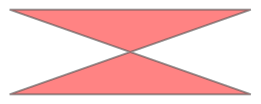

In [20]:
polygon

In [37]:
(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length))),(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length))),(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length))),(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length)))

((760, 76), (646, 76), (646, 37), (760, 37))

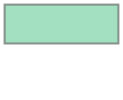

In [36]:
polygon = Polygon([(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length))),(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][2] + (0.35 * b_length))),(int(b[2][0][1] - (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length))),(int(b[2][0][3] + (b_length - (0.5*b_width))),int(b[2][0][0] + (0.65 * b_length)))])
polygon

In [43]:
intersection.area

11900.0

In [42]:
polygon.area, other_polygon.area

(18012.0, 16200.0)

In [174]:
dct

{0: [571, 351, [(280, 534, 423, 608)]],
 1: [1123, 529, [(441, 1082, 618, 1164)]],
 3: [125, 650, [(581, 88, 720, 162)]],
 4: [527, 186, [(130, 507, 242, 548)]],
 5: [579, 198, [(139, 563, 258, 596)]],
 6: [625, 86, [(39, 605, 134, 645)]],
 7: [241, 184, [(108, 217, 261, 265)]],
 8: [1008, 56, [(10, 980, 103, 1037)]],
 9: [155, 252, [(159, 126, 345, 185)]],
 10: [691, 33, [(0, 674, 66, 708)]],
 11: [771, 23, [(2, 762, 45, 781)]],
 12: [507, 667, [(617, 459, 718, 555)]]}

In [132]:
(b[2][0][1],b[2][0][0]),(b[2][0][3],b[2][0][2])

((683, 7), (711, 75))

In [127]:
box

(252, 7, 392, 63)

In [126]:
(box[3] - box[1])

56

In [122]:
((b[2][0][3] - b[2][0][1]),int((b[2][0][3] - b[2][0][1])/2))

(18, 9)

In [111]:
(b[2][0][3] - b[2][0][1]) 

(605, 509, 717, 574)

In [96]:
# pts_src = np.float32([517, 7, 1361, 27, 1245, 767, 19,763,5,283, 503,7]).reshape(4, 1, -1)
inp = cv2.imread('sample_vid.png')
out = cv2.imread('2d.jpg')

pts_src = np.float32([517, 7, 1361, 27, 1245, 767, 19,763,5,283]).reshape(5, 1, -1)
pts_dst = np.float32([0, 0, 336, 0, 336, 388,0, 388,0,186 ]).reshape(5, 1, -1)
h = cv2.findHomography(pts_src, pts_dst,cv2.RANSAC)[0]

in_pt = np.float32([125, 275]).reshape(1, 1, -1)
out_pt = cv2.perspectiveTransform(in_pt, h)

cv2.circle(inp, (int(in_pt[0][0][0]),int(in_pt[0][0][1])), 5, (255,25,0), -1)
cv2.circle(out, (int(out_pt[0][0][0]),int(out_pt[0][0][1])), 5, (255,25,0), -1)
print(out_pt)
cv2.imwrite('in.png',inp)
cv2.imwrite('out.png',out)

[[[-70.69326 173.78682]]]


True

In [ ]:
# in_pt[0][0][0]

In [65]:
pts_src

array([[[ 517.,    7.]],

       [[1361.,   27.]],

       [[1245.,  767.]],

       [[  19.,  763.]],

       [[   5.,  283.]],

       [[ 503.,    7.]]], dtype=float32)